In [1]:
# add current directory to path
import sys
sys.path.insert(0, '..')

import pycwb

print("Version used for this test: %s" % pycwb.__version__)

Welcome to JupyROOT 6.26/10
Loading wavelet library
Trying to load wavelet library from /home/alessandro.martini/.conda/envs/pycwb_test/lib/python3.11/site-packages/lib/wavelet.so
Version used for this test: 0.30.2.dev23+ge1b92b0


25-11-19 15:50:31 - logger_init - INFO - Logging initialized
25-11-19 15:50:31 - logger_init - INFO - Logging level: INFO
25-11-19 15:50:31 - logger_init - INFO - Logging file: None
Repeat injection: 10
Rate: 0.005
Jitter: 50
Sky distribution: {'type': 'Fixed', 'coordinates': {'unit': 'deg', 'phi': -110, 'theta': 50}}
25-11-19 15:50:31 - import_function - INFO - Successfully imported function 'get_injection_parameters' from 'injection_parameters.py'
25-11-19 15:50:31 - get_injection_list_from_parameters - INFO - 6400 injection parameters generated
Number of injections: 6400
Number of injections after repeat: 64000
25-11-19 15:50:31 - distribute_inj_in_gps_time_by_rate - INFO - Distributing 64000 injections in 10800 s with rate 0.005 and jitter 50
25-11-19 15:50:31 - distribute_inj_in_gps_time_by_rate - INFO - Using 1186 data repeats to distribute 64000 injections, each trail contains 54 injections


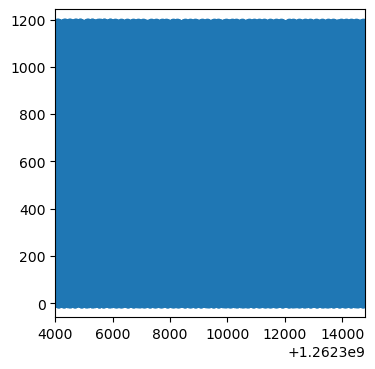

In [12]:
from pycwb.config import Config
from pycwb.modules.logger import logger_init
from pycwb.modules.injection.par_generator import get_injection_list_from_parameters, repeat
from pycwb.modules.injection.sky_distribution import generate_sky_distribution, distribute_injections_on_sky
from pycwb.modules.injection.injection import distribute_inj_in_gps_time_by_rate
from math import ceil
import numpy as np

logger_init()

injection = {
    'rate': '1/200',
    'jitter': 50,
    'allow_reuse_data': True,
    'repeat_injection': 10,
    'sky_distribution': {
        'type': 'Fixed',
        'coordinates': {
            'unit': 'deg',
            'phi': -110,
            'theta': 50
        }
    },
    'parameters_from_python': {
        'function': 'injection_parameters.py.get_injection_parameters',
    },
    'approximant': 'Ringdown',
    'generator': {
        'module': './input/waveform.py', 
        'function': 'get_td_waveform'
    }
}


repeat_injection = injection['repeat_injection']
rate = eval(injection['rate'])
jitter = injection['jitter']
sky_distribution = injection['sky_distribution']

print(f"Repeat injection: {repeat_injection}")
print(f"Rate: {rate}")
print(f"Jitter: {jitter}")
print(f"Sky distribution: {sky_distribution}")

total_live_time = 3600 * 3 
start_gps_time = 1262304000
end_gps_time = start_gps_time + total_live_time
injections = get_injection_list_from_parameters(injection)
print(f"Number of injections: {len(injections)}")
injections = repeat(injections, repeat_injection)
print(f"Number of injections after repeat: {len(injections)}")


%matplotlib inline
import matplotlib.pyplot as plt

distribute_inj_in_gps_time_by_rate(injections, rate, jitter, start_gps_time, end_gps_time, shuffle=False)

plt.figure(figsize=(4, 4))
plt.plot([inj['gps_time'] for inj in injections], [inj['trail_idx'] for inj in injections], 'o')
plt.xlim(start_gps_time, end_gps_time)
plt.show()

## Patch sky distribution

25-11-19 15:52:14 - generate_sky_distribution - INFO - Generating sky distribution of type: Patch with 64000 samples
25-11-19 15:52:14 - generate_sky_distribution - INFO - Generating points in a small circular patch around a center RA/Dec
25-11-19 15:52:14 - generate_sky_distribution - INFO - Patch generation uses degree internally, and will return RA/Dec in radians for injection.
25-11-19 15:52:14 - generate_sky_distribution - INFO - Center Phi: 45 degrees, Center Theta: 45 degrees, Radius: 10 degrees
25-11-19 15:52:14 - generate_sky_distribution - INFO - Generating points in a small circular patch around a center Phi/Theta
Number of sky locations: 64000
25-11-19 15:52:14 - distribute_injections_on_sky - INFO - Distributing 64000 injections on sky locations with coordsys: geo
Number of injections after sky distribution: 64000


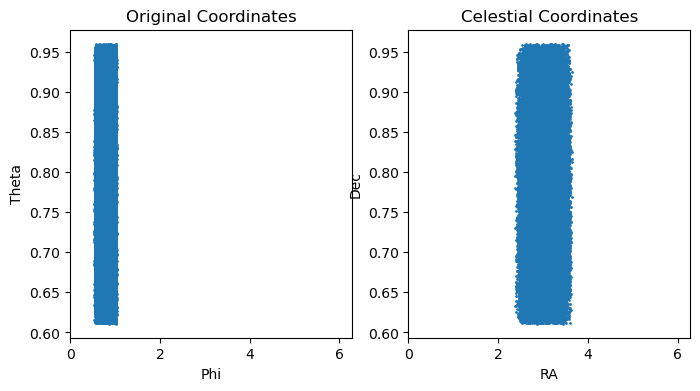

In [16]:
%matplotlib inline
from pycwb.utils.skymap_coord import convert_to_celestial_coordinates
import matplotlib.pyplot as plt

sky_distribution = {
    'type': 'Patch',
    'coordsys': 'geo', 
    'patch': {
        'unit': 'deg',
        'center': {'phi': 45, 'theta': 45},
        'radius': 10
    }
}

sky_locations = generate_sky_distribution(sky_distribution, len(injections))
print(f"Number of sky locations: {len(sky_locations[0])}")
distribute_injections_on_sky(injections, sky_locations, coordsys=sky_distribution['coordsys'])
print(f"Number of injections after sky distribution: {len(injections)}")

phi = np.array([inj['sky_loc'][0] for inj in injections])
theta = np.array([inj['sky_loc'][1] for inj in injections])

celestial_coordinates = [convert_to_celestial_coordinates(inj['sky_loc'][0], inj['sky_loc'][1], inj['gps_time'], inj['coordsys']) for inj in injections] 

ras = np.array([coord[0] for coord in celestial_coordinates])
decs = np.array([coord[1] for coord in celestial_coordinates]) 

# plot sky distribution
fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].scatter(phi, theta, s=1)
ax[1].scatter(ras, decs, s=1) 
ax[0].set_title('Original Coordinates')
ax[0].set_xlabel('Phi')
ax[0].set_ylabel('Theta')
ax[1].set_title('Celestial Coordinates')
ax[1].set_xlabel('RA')
ax[1].set_ylabel('Dec')
ax[0].set_xlim(0,2*np.pi)
ax[1].set_xlim(0,2*np.pi)
plt.show()


## Distribute at a Fixed Point

25-11-19 15:51:47 - generate_sky_distribution - INFO - Generating sky distribution of type: Fixed with 64000 samples
25-11-19 15:51:47 - generate_sky_distribution - INFO - Converting phi/theta from degrees to radians
Number of sky locations: 64000
25-11-19 15:51:47 - distribute_injections_on_sky - INFO - Distributing 64000 injections on sky locations with coordsys: geo
Number of injections after sky distribution: 64000


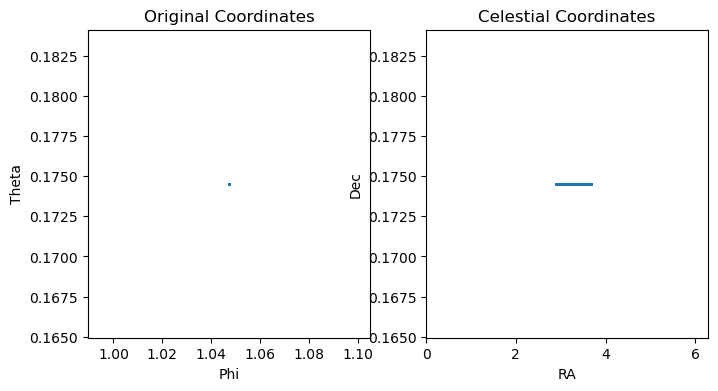

In [15]:

%matplotlib inline
from pycwb.utils.skymap_coord import convert_to_celestial_coordinates
import matplotlib.pyplot as plt

sky_distribution = {
    'type': 'Fixed',
    'coordsys': 'geo',
    'coordinates': {
        'unit': 'deg',
        'sky_loc': {'phi': 60, 'theta': 10} 
    }
}


sky_locations = generate_sky_distribution(sky_distribution, len(injections))
print(f"Number of sky locations: {len(sky_locations[0])}")
distribute_injections_on_sky(injections, sky_locations, coordsys=sky_distribution['coordsys'])
print(f"Number of injections after sky distribution: {len(injections)}")

phi = np.array([inj['sky_loc'][0] for inj in injections])
theta = np.array([inj['sky_loc'][1] for inj in injections])

celestial_coordinates = [convert_to_celestial_coordinates(inj['sky_loc'][0], inj['sky_loc'][1], inj['gps_time'], inj['coordsys']) for inj in injections] 

ras = np.array([coord[0] for coord in celestial_coordinates])
decs = np.array([coord[1] for coord in celestial_coordinates]) 

# plot sky distribution
fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].scatter(phi, theta, s=1)
ax[1].scatter(ras, decs, s=1) 
ax[0].set_title('Original Coordinates')
ax[0].set_xlabel('Phi')
ax[0].set_ylabel('Theta')
ax[1].set_title('Celestial Coordinates')
ax[1].set_xlabel('RA')
ax[1].set_ylabel('Dec')
ax[1].set_xlim(0,2*np.pi)
plt.show()
